# Notes

* `d2['file_scores'][k]['paths']` is a matrix of all-pairs segment-to-segment alignments
  * indices are relative to the segment in question
  * same..`['scores']` is the alignment scores: 
  * use `< thresholds['none']` to find the good segment pairs
* generate data from
  * isophonics functions
  * salami functions
  * l2 norm
* samples:
  * features = patches of cqt +- 5 frames on either side
  * positives = drawn from pairs of segments below threshold
  * negatives = "" above the threshold
* model evaluation
  * serra method or laplacian

In [108]:
import numpy as np
import librosa
import cPickle as pickle
import numba

In [109]:
def symstack(X, n_steps=5, delay=1, **kwargs):
    '''Symmetric history stacking.
    
    like librosa.feature.stack_memory, but IN THE FUTURE!!!
    '''
    rpad = n_steps * delay
    Xpad = np.pad(X,
                  [(0, 0), (0, rpad)],
                  **kwargs)
    
    Xstack = librosa.feature.stack_memory(Xpad,
                                          n_steps=2 * n_steps + 1,
                                          delay=delay,
                                          **kwargs)
    
    return Xstack[:, rpad:]

In [110]:
def load_feature_data(file_name, n_steps=5):
    
    fname = '../data/features/{}.pk'.format(file_name)
    
    data = pickle.load(open(fname, 'r'))
    
    return symstack(data['cqgram'].astype(np.float32),
                    n_steps=n_steps,
                    mode='edge'), data['intframes']

In [111]:
@numba.jit
def get_feature_paths(X_raw, t_i, t_j):
    
    X = np.empty((len(t_i), X_raw.shape[0]), dtype=X_raw.dtype)
    
    for k, (i, j) in enumerate(zip(t_i, t_j)):
        X[k] = np.abs(X_raw[:, i] - X_raw[:, j])
        
    return X

In [128]:
def make_training_data(paths=None,
                       file_name=None,
                       thresholds=None,
                       labels=None,
                       intervals=None,
                       fmeasures=None,
                       scores=None):
    
    # intframes gives the section->cqt frame alignments
    X_raw, intframes = load_feature_data(file_name)
    
    thresh = thresholds['none']
    
    n_segments = len(paths)
    
    ex_x, ex_y = [], []
    
    for seg_i in range(n_segments):
        off_i = intframes[seg_i, 0]
        
        for seg_j in range(seg_i + 1, len(paths[seg_i])):
            off_j = intframes[seg_j, 0]
            
            if not isinstance(paths[seg_i][seg_j], list):
                continue
                
            if scores[seg_i, seg_j] < thresh:
                y = 1
            else:
                y = 0
                
            # Pull out features from the path
            t_i, t_j = paths[seg_i][seg_j]
            
            X = get_feature_paths(X_raw, t_i + off_i, t_j + off_j)
            ex_x.append(X)
            ex_y.append(y * np.ones(len(X)))
    
    ex_x = np.concatenate(ex_x)
    ex_y = np.concatenate(ex_y)
    return ex_x, ex_y

In [ ]:
def process_file(file_scores):
    
    if file_scores['paths']:
        X, Y = make_training_data(**file_scores)
        
        

In [59]:
all_data = pickle.load(open('../data/scores_datasetESALAMI_levelEfunction_distEL2.pk'))
#all_data = pickle.load(open('../data/scores_datasetEIsophonics_levelEfunction_distEL2.pk'))

In [133]:
all_data['file_scores'][2].keys()

['paths',
 'file_name',
 'thresholds',
 'labels',
 'intervals',
 'fmeasures',
 'scores']

In [134]:
all_data['file_scores'][2]

{'file_name': 'SALAMI_748.mp3',
 'fmeasures': None,
 'intervals': None,
 'labels': None,
 'paths': None,
 'scores': None,
 'thresholds': None}

In [131]:
X, Y = make_training_data(**all_data['file_scores'][2])

TypeError: 'NoneType' object has no attribute '__getitem__'

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

True

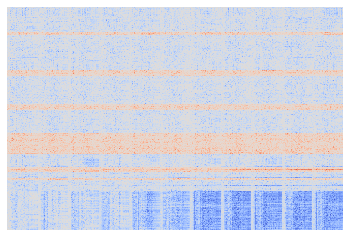

In [130]:
librosa.display.specshow( (-1 + 2 * Y[:, np.newaxis]) * X)